In [1]:
import networkx as nx
import altair as alt
import nx_altair as nxa
from nx_altair.core import to_pandas_nodes

alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [10]:
G = nx.read_gml('/mnt/data/hDHFR_modSAR_graph.gml')
pos = nx.kamada_kawai_layout(G, scale=0.7)
#pos = nx.spectral_layout(G)

In [3]:
G.nodes()['CHEMBL104787']

{'bestFold': 20,
 'community': 'm03',
 'degree': 8,
 'infomap': 'm12',
 'k': 0,
 'louvain': 'm03',
 'module': 'm03',
 'smiles': 'COc1ccc(OC)c(Cc2sc3nc(N)nc(N)c3c2C)c1',
 'threshold': 0.3}

In [14]:
comm_sort = to_pandas_nodes(G, pos)['oplraregregion'].value_counts().sort_index()
comm_sort

region 1    302
region 2     76
Name: oplraregregion, dtype: int64

In [11]:
to_pandas_nodes(G, pos).columns

Index(['infomap', 'x', 'louvain', 'smiles', 'threshold', 'degree', 'module', 'k', 'oplraregregion', 'bestFold', 'y', 'community'], dtype='object')

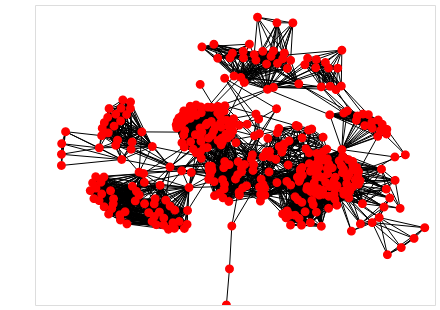

In [12]:
# Draw the graph using Altair
viz = nxa.draw_networkx(
    G=G,
    pos=pos,
    node_size=80,
    alpha=1.0)

viz.interactive()

In [15]:
alt.Scale(domain=comm_sort.index.tolist(), range=color_strong_range)

Scale({
  domain: ['region 1', 'region 2'],
  range: ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#C7C7C7']
})

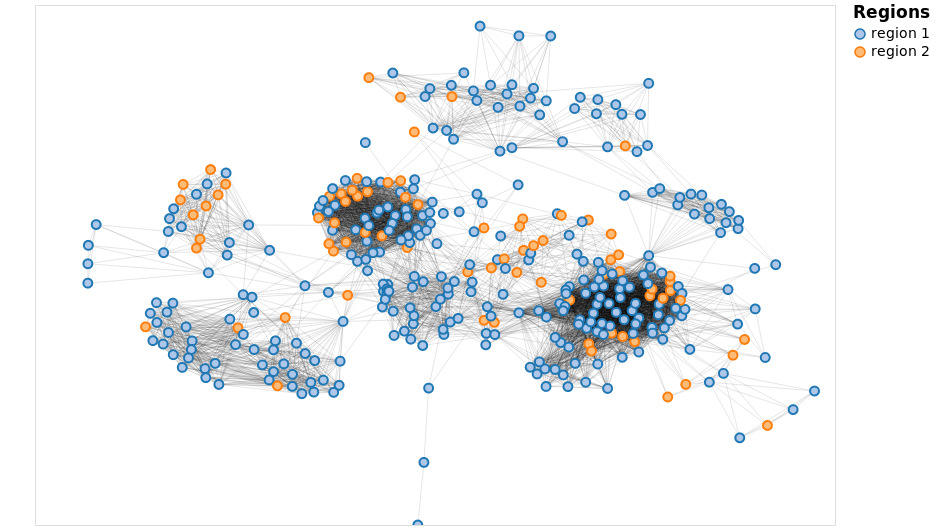

In [17]:
edges = viz.layer[0]
nodes = viz.layer[1]
color_range = ["#AEC7E8", "#FFBB78", "#98DF8A", "#FF9896", "#C5B0D5", "#C49C94", "#F7B6D2", "#C7C7C7"]
color_strong_range = ["#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD", "#8C564B", "#E377C2", "#C7C7C7"]

edges = edges.encode(
    opacity=alt.value(0.1)
)

nodes = nodes.encode(
    stroke = alt.Color('oplraregregion', title='Regions',
                   scale=alt.Scale(domain=comm_sort.index.tolist(),
                                   range=color_strong_range)),
    fill=alt.Color('oplraregregion', title='Regions', 
                   scale=alt.Scale(domain=comm_sort.index.tolist(),
                                   range=color_range))
)

viz = alt.layer(edges, nodes)

viz.configure_axis(
        ticks=False,
        grid=False,
        domain=False,
        labels=False,
    ).configure_legend(
  titleFontSize=17,
  labelFontSize=14,

).properties(width=800, height=520).interactive()

# Common Core

In [18]:
from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit.Geometry
from rdkit.Chem import rdFMCS
from rdkit.Chem.Draw import IPythonConsole 

In [19]:
molecules_df = to_pandas_nodes(G, pos)
molecules_df.head()

infomap         x louvain    ...    bestFold          y community
CHEMBL104787      m12 -0.191918     m03    ...          20 -0.0814808       m03
CHEMBL10592       m01  0.221159     m01    ...          20  -0.157533       m01
CHEMBL106699      m01  0.249918     m01    ...          20 -0.0642683       m01
CHEMBL10804       m01  0.237093     m01    ...          20  -0.183385       m01
CHEMBL1080403     m11  0.328185     m09    ...          20  -0.355274       m09

[5 rows x 12 columns]

In [27]:
m01 = molecules_df[molecules_df['oplraregregion'] == 'region 2']
m01.head()

infomap          x louvain    ...    bestFold          y community
CHEMBL104787      m12  -0.191918     m03    ...          20 -0.0814808       m03
CHEMBL10804       m01   0.237093     m01    ...          20  -0.183385       m01
CHEMBL1080403     m11   0.328185     m09    ...          20  -0.355274       m09
CHEMBL1091255     m09  0.0829511     m08    ...          20 -0.0202269       m08
CHEMBL1092451     m09    0.12571     m08    ...          20   0.065848       m08

[5 rows x 12 columns]

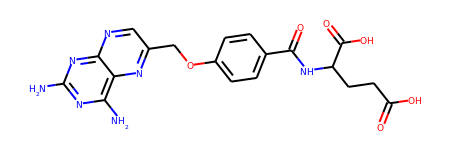

In [28]:
highest_degree_id = m01['degree'].astype(int).idxmax()
highest_degree_mol = Chem.MolFromSmiles(m01.loc[highest_degree_id]['smiles'])
highest_degree_mol

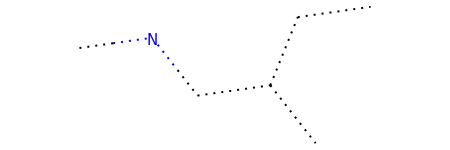

In [29]:
res=rdFMCS.FindMCS([Chem.MolFromSmiles(mol) for mol in m01['smiles']])
pattern = Chem.MolFromSmarts(res.smartsString)
pattern

In [30]:
matching = highest_degree_mol.GetSubstructMatch(pattern)

Chem.Draw.MolToFile(highest_degree_mol, 'r02_pattern.svg', size=(170, 80), highlightAtoms=matching)